# Entrenamiento Local para Aprendizaje Federado

## Importamos las librerias

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from model import create_model, save_model, load_model

np.random.seed(42)
tf.random.set_seed(42)

## Cargamos datos del cliente

In [ ]:
CLIENT_ID = 1  

client_data_file = f"client_data/client_{CLIENT_ID}_data.pkl"

with open(client_data_file, 'rb') as f:
    x_train, y_train = pickle.load(f)

test_data_file = "test_data/test_data.pkl"
with open(test_data_file, 'rb') as f:
    x_test, y_test = pickle.load(f)

print(f"Datos del cliente {CLIENT_ID} cargados.")

Datos del cliente 1 cargados.
Tamaño del conjunto de entrenamiento: 15000 muestras
Tamaño del conjunto de prueba: 10000 muestras


## Exploramos los Datos

Distribución de clases en los datos de entrenamiento:
  Dígito 0: 1495 muestras (9.97%)
  Dígito 1: 1649 muestras (10.99%)
  Dígito 2: 1471 muestras (9.81%)
  Dígito 3: 1518 muestras (10.12%)
  Dígito 4: 1443 muestras (9.62%)
  Dígito 5: 1383 muestras (9.22%)
  Dígito 6: 1482 muestras (9.88%)
  Dígito 7: 1635 muestras (10.90%)
  Dígito 8: 1445 muestras (9.63%)
  Dígito 9: 1479 muestras (9.86%)


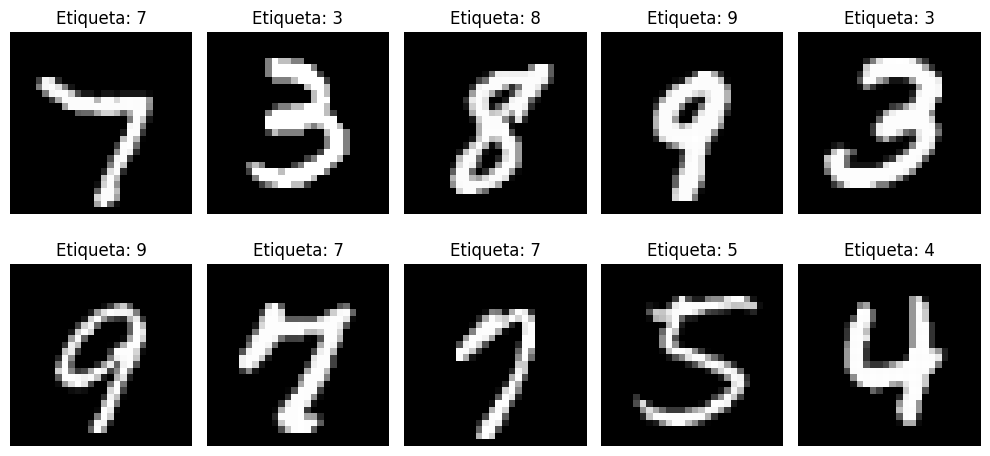

In [ ]:
class_distribution = np.bincount(y_train, minlength=10)
print("Distribución de clases en los datos de entrenamiento:")
for digit, count in enumerate(class_distribution):
    print(f"  Dígito {digit}: {count} muestras ({count/len(y_train)*100:.2f}%)")

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Etiqueta: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Cargamos el Modelo Global Inicial

In [13]:
global_model_path = "modelo_global.h5"

if os.path.exists(global_model_path):
    model = load_model(global_model_path)
    print(f"Modelo global cargado desde: {global_model_path}")
else:
    model = create_model()
    print("Nuevo modelo global creado.")

model.summary()

Nuevo modelo global creado.


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,410 (1.49 MB)

 Trainable params: 390,410 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamos Modelo Localmente

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32

class TrainingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TrainingCallback, self).__init__()
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_accuracies.append(logs.get('val_accuracy'))
        print(f"Epoch {epoch+1}/{EPOCHS} - "
              f"loss: {logs.get('loss'):.4f} - "
              f"accuracy: {logs.get('accuracy'):.4f} - "
              f"val_loss: {logs.get('val_loss'):.4f} - "
              f"val_accuracy: {logs.get('val_accuracy'):.4f}")

training_callback = TrainingCallback()

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    callbacks=[training_callback],
    verbose=0
)

Epoch 1/5 - loss: 0.3373 - accuracy: 0.8911 - val_loss: 0.0684 - val_accuracy: 0.9761
Epoch 2/5 - loss: 0.0957 - accuracy: 0.9707 - val_loss: 0.0585 - val_accuracy: 0.9812
Epoch 3/5 - loss: 0.0603 - accuracy: 0.9805 - val_loss: 0.0460 - val_accuracy: 0.9842
Epoch 4/5 - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.0457 - val_accuracy: 0.9858
Epoch 5/5 - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0445 - val_accuracy: 0.9873


## Evaluamos el Modelo Entrenado Localmente

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

Pérdida en el conjunto de prueba: 0.0445
Precisión en el conjunto de prueba: 0.9873


## Guardamos el Modelo Entrenado Localmente

In [ ]:
local_model_path = f"modelo_local_cliente_{CLIENT_ID}.h5"
save_model(model, local_model_path)
print(f"Modelo local guardado en: {local_model_path}")

import pickle
weights = model.get_weights()
with open(f"pesos_cliente_{CLIENT_ID}.pkl", 'wb') as f:
    pickle.dump(weights, f)
print(f"Pesos del modelo guardados en: pesos_cliente_{CLIENT_ID}.pkl")

Modelo local guardado en: modelo_local_cliente_1.h5
Pesos del modelo guardados en: pesos_cliente_1.pkl
